<a href="https://colab.research.google.com/github/jemalmgr/AH2179/blob/main/Hand_In_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AH2179 Hand-In Assignment 2
## Use text classification for traffic sentimental analysis
By Jennifer Malmgren

### Data preparation

In [1]:
# Load the dataset

import pandas as pd
import os

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_4_Text_classification/Pakistani%20Traffic%20sentiment%20Analysis.csv'
df = pd.read_csv(url)

pd.set_option('display.max_colwidth', None)
df.head(10)

,Text,Sentiment
0,Adayala road is clear,0
1,Traffic jam from parbat rd to nazim-ud-din rd islamabad,1
2,Mandra is clear,0
3,Fort street is clear,0
4,"Mashriq Hotel towards Fawara Chowk, City Saddar Road is closed for traffic",1
5,Traffic jam from gulberg expy to margalla ave,1
6,Korang Rd road is free,0
7,Road open from Cantt Station to Lucky star,0
8,Zagid baig is clear,0
9,Traffic open from jaffar khan openali rd to service road S islamabad,0


In [2]:
# Get summary of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2109 non-null   object
 1   Sentiment  2109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [3]:
# Check the sentiment (0=positive, 1=negative)

df.groupby('Sentiment').describe()

Text                                                               \
          count unique                                                   top   
Sentiment                                                                      
0          1010   1008                      Traffic open at shahrah e faisal   
1          1099   1079  Road is closed for traffic at star gate towards city   

                
          freq  
Sentiment       
0            2  
1            3

In [4]:
# Drop duplicates

df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text         \
          count unique   
Sentiment                
0          1008   1008   
1          1079   1079   

                                                                         
                                                               top freq  
Sentiment                                                                
0                                            Adayala road is clear    1  
1          Traffic jam from parbat rd to nazim-ud-din rd islamabad    1

### Modeling

In [5]:
# Split the data

x = df['Text']
y = df['Sentiment']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [6]:
# Grid search with multiple vectorizers and models using pipelines

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

pipelines = {
    'lr': Pipeline([
        ('vectorizer', CountVectorizer()),
        ('model', LogisticRegression())]),
    'knn': Pipeline([
        ('vectorizer', CountVectorizer()),
        ('model', KNeighborsClassifier())]),
    'rf': Pipeline([
        ('vectorizer', CountVectorizer()),
        ('model', RandomForestClassifier())]),
    'xgb': Pipeline([
        ('vectorizer', CountVectorizer()),
        ('model', XGBClassifier())]),
    'svm': Pipeline([
        ('vectorizer', CountVectorizer()),
        ('model', SVC())]),
    'nb': Pipeline([
        ('vectorizer', CountVectorizer()),
        ('model', BernoulliNB())])
    }

vectorizers = [
    CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=20),
    HashingVectorizer(ngram_range=(1, 2), n_features=200), TfidfVectorizer(),
    TfidfVectorizer(min_df=20, norm='l2', smooth_idf=True, use_idf=True, ngram_range=(1, 2), stop_words='english')]

param_grids = {
    'lr': {
        'vectorizer': vectorizers,
        'model__max_iter': [500, 1000],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__random_state': [0]
    },
    'knn': {
        'vectorizer': vectorizers,
        'model__n_neighbors': [3, 5, 7]
    },
    'rf': {
        'vectorizer': vectorizers,
        'model__n_estimators': [100, 500],
        'model__max_depth': [20, 50],
        'model__random_state': [0]
    },
    'xgb': {
        'vectorizer': vectorizers,
        'model__n_estimators': [100, 500],
        'model__eta': [0.05, 0.1],
        'model__max_depth': [3, 9]
    },
    'svm': {
        'vectorizer': vectorizers,
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__kernel': ['linear', 'rbf']
    },
    'nb': {
        'vectorizer': vectorizers,
        'model__alpha': [0.1, 1, 10]
    }
}

best_models = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'Best model parameters and vectorizer for {name}:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_, end='\n\n')

Best model parameters and vectorizer for lr: {'model__C': 100, 'model__max_iter': 500, 'model__random_state': 0, 'vectorizer': TfidfVectorizer()}
Best score: 0.9808293323263383

Best model parameters and vectorizer for knn: {'model__n_neighbors': 7, 'vectorizer': HashingVectorizer(n_features=200, ngram_range=(1, 2))}
Best score: 0.9376939814065564

Best model parameters and vectorizer for rf: {'model__max_depth': 50, 'model__n_estimators': 500, 'model__random_state': 0, 'vectorizer': TfidfVectorizer()}
Best score: 0.9778317239395085

Best model parameters and vectorizer for xgb: {'model__eta': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500, 'vectorizer': TfidfVectorizer()}
Best score: 0.9802305299311287

Best model parameters and vectorizer for svm: {'model__C': 10, 'model__kernel': 'linear', 'vectorizer': TfidfVectorizer()}
Best score: 0.9820323317329306

Best model parameters and vectorizer for nb: {'model__alpha': 10, 'vectorizer': TfidfVectorizer()}
Best score: 0.964050277

lr model
Accuracy: 0.9856459330143541
Precision: 0.9902439024390244
F1-score: 0.9854368932038836

knn model
Accuracy: 0.9569377990430622
Precision: 0.9655172413793104
F1-score: 0.9560975609756097

rf model
Accuracy: 0.9904306220095693
Precision: 0.9903381642512077
F1-score: 0.9903381642512077

xgb model
Accuracy: 0.9832535885167464
Precision: 0.9901960784313726
F1-score: 0.9829683698296837

svm model
Accuracy: 0.9880382775119617
Precision: 0.9950980392156863
F1-score: 0.9878345498783455

nb model
Accuracy: 0.9593301435406698
Precision: 0.9947916666666666
F1-score: 0.9573934837092731



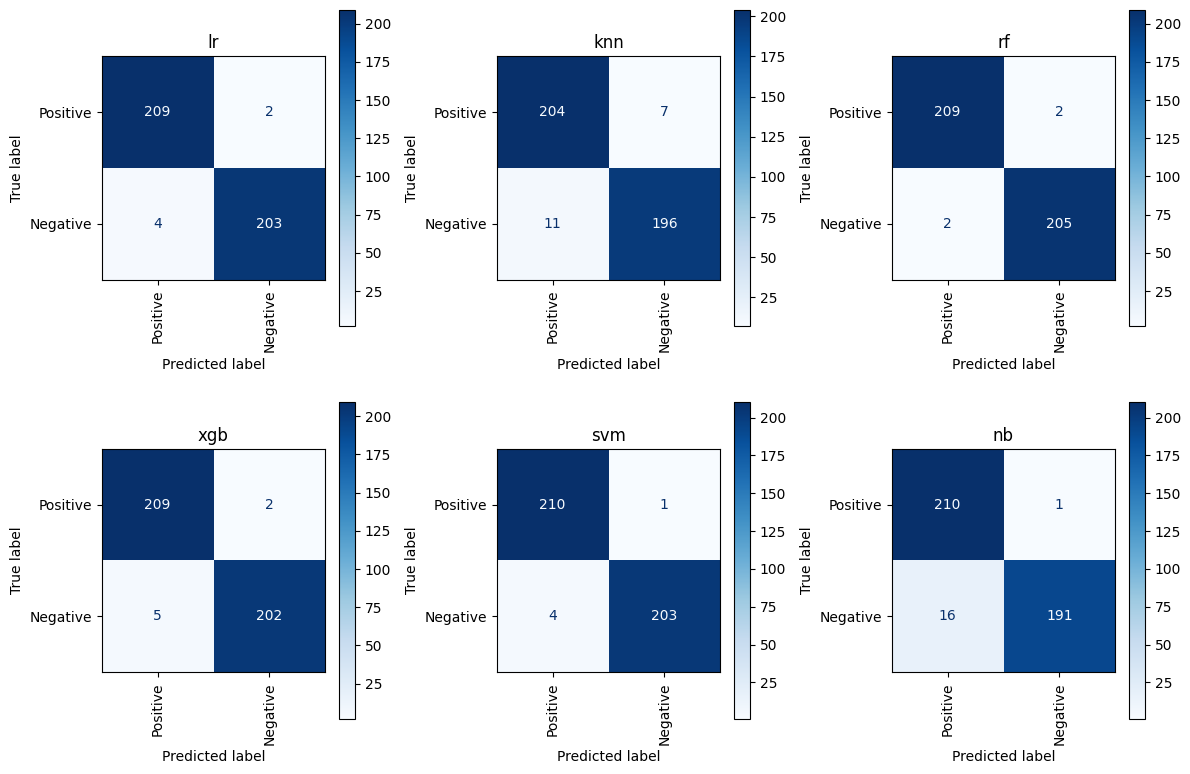

In [7]:
# Review performance

from sklearn.metrics import ConfusionMatrixDisplay as cmd, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, (name, model) in enumerate(best_models.items()):
    y_pred = best_models[name].predict(x_test)

    ax = axes[i]
    cmd.from_estimator(
        model,
        x_test,
        y_test,
        display_labels=['Positive', 'Negative'],
        cmap='Blues',
        ax=ax,
        xticks_rotation='vertical')
    ax.set_title(f'{name}')

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name} model')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('F1-score:', f1, end='\n\n')

plt.tight_layout()
plt.show()